In [1]:
import h5py
import numpy as np

files = ['../Data/ModelNet40_train/ply_data_train0.h5',
         '../Data/ModelNet40_train/ply_data_train1.h5',
         '../Data/ModelNet40_train/ply_data_train2.h5',
         '../Data/ModelNet40_train/ply_data_train3.h5',
         '../Data/ModelNet40_train/ply_data_train4.h5']
#files = ['../Data/ModelNet10_train/modelnet10_train.h5']
d = []
l = []

for i in range(len(files)):
    fh5 = h5py.File(files[0], 'r')
    data = fh5['data'][:]
    label = fh5['label'][:]
    fh5.close()
    if(i != 0):
        d = np.append(d, data, axis=0)
        l = np.append(l, label, axis=0)
    else:
        d = data
        l = label

print d.shape
print l.shape

(10240, 2048, 3)
(10240, 1)


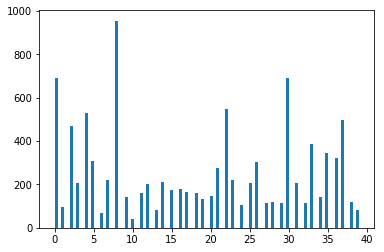

In [2]:
import matplotlib.pyplot as plt
plt.hist(l, bins=100)
plt.show()

In [3]:
from keras.utils import to_categorical
Y_train = to_categorical(l)
classes = Y_train.shape[1]
print Y_train.shape
print "Loaded dataset with %s classes"%(classes)

Using TensorFlow backend.


(10240, 40)
Loaded dataset with 40 classes


In [4]:
from tqdm import trange
# now we need to voxelize that point cloud...
def voxelize(dim, data):
    # uncomment below if you have not already normalized your object to [0,1]^3
    #m = max(x.min(), x.max(), key=abs)
    #data /= m # This puts the data in [0,1]
    data *= (dim/2) # This puts the data in [0,dim]
    data += (dim/2) 
    data = np.asarray([[int(i[0]), int(i[1]), int(i[2])] for i in data])
    data = np.unique(data, axis=1)
    retval = np.zeros((dim, dim, dim))
    for i in data:
        retval[i[0]][i[1]][i[2]] = 1
    retval = np.asarray([retval])
    return retval

X_train = [voxelize(32, i) for i in d]

In [5]:
X_train = np.asarray(X_train)
X_train = np.reshape(X_train, (-1, 32, 32, 32, 1))
print X_train.shape

(10240, 32, 32, 32, 1)


In [6]:
files = ['../Data/ModelNet40_test/ply_data_test0.h5',
              '../Data/ModelNet40_test/ply_data_test1.h5']

d = []
l = []

for i in range(len(files)):
    fh5 = h5py.File(files[0], 'r')
    data = fh5['data'][:]
    label = fh5['label'][:]
    fh5.close()
    if(i != 0):
        d = np.append(d, data, axis=0)
        l = np.append(l, label, axis=0)
    else:
        d = data
        l = label

print d.shape
print l.shape

Y_test = to_categorical(l)
X_test = [voxelize(32, i) for i in d]
X_test = np.asarray(X_test)
X_test = np.reshape(X_test, (-1, 32, 32, 32, 1))

(4096, 2048, 3)
(4096, 1)


In [7]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Convolution3D, MaxPooling3D
from keras.layers import Conv3D
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
from keras.optimizers import SGD
import random
import numpy as np

num_classes = classes

# Defining VoxNet in Keras 2
model = Sequential()
model.add(Conv3D(input_shape=(32, 32, 32, 1), filters=32, 
                 kernel_size=(5,5,5), strides=(2, 2, 2)))
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(Dropout(rate=0.3))
model.add(Conv3D(filters=32, kernel_size=(3,3,3)))
model.add(Activation(LeakyReLU(alpha=0.1)))
model.add(MaxPooling3D(pool_size=(2, 2, 2), strides=None))
model.add(Dropout(rate=0.4))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(units=num_classes, kernel_initializer='normal', activation='relu'))
model.add(Activation("softmax"))
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=["accuracy"])
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_1 (Conv3D)            (None, 14, 14, 14, 32)    4032      
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 14, 32)    0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 14, 32)    0         
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 12, 12, 12, 32)    27680     
_________________________________________________________________
activation_2 (Activation)    (None, 12, 12, 12, 32)    0         
_________________________________________________________________
max_pooling3d_1 (MaxPooling3 (None, 6, 6, 6, 32)       0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 6, 6, 6, 32)       0         
__________

/usr/local/lib/python2.7/dist-packages/keras/activations.py:103: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  ).format(identifier=identifier.__class__.__name__))


In [10]:
history = model.fit(x=X_train, y=Y_train, batch_size=16, 
                    epochs=25, verbose=1, validation_data=(X_test, Y_test))

Train on 10240 samples, validate on 4096 samples
Epoch 1/25
10240/10240 [==============================] - 5s - loss: 0.2134 - acc: 0.9272 - val_loss: 1.9852 - val_acc: 0.6299
Epoch 2/25
10240/10240 [==============================] - 5s - loss: 0.1999 - acc: 0.9334 - val_loss: 1.9680 - val_acc: 0.6299
Epoch 3/25
10240/10240 [==============================] - 5s - loss: 0.1952 - acc: 0.9311 - val_loss: 2.0854 - val_acc: 0.6343
Epoch 4/25
10240/10240 [==============================] - 5s - loss: 0.1826 - acc: 0.9374 - val_loss: 2.0867 - val_acc: 0.6377
Epoch 5/25
10240/10240 [==============================] - 5s - loss: 0.1834 - acc: 0.9357 - val_loss: 2.1404 - val_acc: 0.6294
Epoch 6/25
10240/10240 [==============================] - 5s - loss: 0.1698 - acc: 0.9421 - val_loss: 2.1168 - val_acc: 0.6392
Epoch 7/25
10240/10240 [==============================] - 5s - loss: 0.1543 - acc: 0.9451 - val_loss: 2.1695 - val_acc: 0.6357
Epoch 8/25
10240/10240 [==============================] - 5s -

KeyboardInterrupt: 

In [11]:
# serialize model to JSON
from keras.models import model_from_json
import os
#model_json = model.to_json()
#with open("voxnet40.json", "w") as json_file:
#    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("VoxNet-ModelNet40.h5")
print("Saved model to disk")

Saved model to disk
